<a href="https://colab.research.google.com/github/marioapn3/classification_star_galaxy_mobilenetv2/blob/main/Star_Galaxy_MobileV2Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'stars-and-galaxies:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F865179%2F1479286%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240703%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240703T172917Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D00c2f7f4371331943f89aa280561d655caca076cc8dae98524d493e7c2ff584bec331885286bf1c2c327d696748d44670cdd7bcd7bc75e294bc26e7255b81e1216e8e0de4c6f199691b11b2e20e176d04ce159fbff92930e983d65bc61c44f63057be06fe072fee9dc66dd3d7894b2f19180a5c1e586ee07b2ee4048d0e4d11d31559a06d14a99de29c2456351872b6563a2bff9aa74663f60f4c6d1a33d1e5ac9c7034c9d9cae5687ed6656161d30f74097eb8d1e81edee2fbfe0276fb20613ee7488445dfceab6b099d6e444f7ba831fde033dc5abfe57df79b6a6bc15797d3f3ffb4ac1398879751139867fd557519c8149c7f116d794d19a45ec41f6065a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
direct = "../input/stars-and-galaxies/data"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential


In [ ]:
# Path to dataset
train_dir = f'{direct}/train'
val_dir =  f'{direct}/validation'

In [ ]:
# Image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
bs = 32
lr = 0.0001
size = (224, 224)
shape = (224,224, 3)
epochs = 30
batch_size = 32

In [ ]:

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=size,
    batch_size=batch_size,
    class_mode='binary')



Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
sample_training_images, _ = next(train_generator)

In [ ]:
image_batch = sample_training_images[:batch_size]

In [ ]:
import tensorflow as tf
base_model = tf.keras.applications.MobileNetV2(input_shape=shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False




9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
feature_batch = base_model(image_batch)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = model.fit(train_generator,
                    epochs=30,
                    callbacks=[es, mc],
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // validation_generator.batch_size,
                    )

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.7900
Epoch 00001: accuracy improved from -inf to 0.79000, saving model to best_model.h5
250/250 [==============================] - 91s 364ms/step - loss: 0.4546 - accuracy: 0.7900 - val_loss: 0.3168 - val_accuracy: 0.9234
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.2701 - accuracy: 0.9150
Epoch 00002: accuracy improved from 0.79000 to 0.91500, saving model to best_model.h5
250/250 [==============================] - 68s 271ms/step - loss: 0.2701 - accuracy: 0.9150 - val_loss: 0.2312 - val_accuracy: 0.9294
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.2260 - accuracy: 0.9222
Epoch 00003: accuracy improved from 0.91500 to 0.92225, saving model to best_model.h5
250/250 [==============================] - 67s 267ms/step - loss: 0.2260 - accuracy: 0.9222 - val_loss: 0.2052 - val_accuracy: 0.9325
Epoch 4/30
250/250 [==============================] - E

In [ ]:
# x = mobileNet.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
# predictions = Dense(1, activation='sigmoid')(x)  # Add a logistic layer for binary classification

# # Combine the base model and the custom layers into a new model
# model = Model(inputs=mobileNet.input, outputs=predictions)
# # Compile the model
# model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# # Let's take a look at the base model architecture


In [ ]:
# # Train the model
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // validation_generator.batch_size,
#     epochs=30
# )

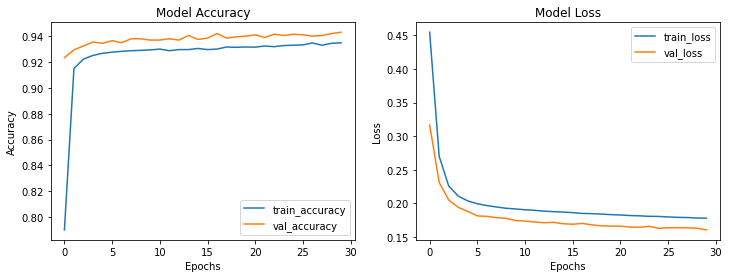

In [ ]:
# Plotting the model accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
print("Class indices:", validation_generator.class_indices)


Class indices: {'galaxy': 0, 'star': 1}


In [ ]:
print(validation_generator.class_indices)


{'galaxy': 0, 'star': 1}
